In [16]:
import numpy as np
import pandas as pd
import numpy.random as npr
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from scipy.stats import norm, linregress
import seaborn as sns
from scipy.integrate import trapz

1\. **Kernel Density Estimate**

Produce a KDE for a given distribution (by hand, not using seaborn!):

* Fill a numpy array, x,  of len(N) (with N=O(100)) with a variable normally distributed, with a given mean a standard deviation
* Fill an histogram in pyplot taking properly care about the aesthetic
   * use a meaningful number of bins
   * set a proper y axis label
   * set proper value of x axis major ticks labels (e.g. you want to display only integer labels)
   * display the histograms as data points with errors (the error being the poisson uncertainty)
* for every element of x, create a gaussian with the mean corresponding the element value and std as a parameter that can be tuned. The std default value should be:
$$ 1.06 * x.std() * x.size ^{-\frac{1}{5.}} $$
you can use the scipy function `stats.norm()` for that.
* In a separate plot (to be placed beside the original histogram), plot all the gaussian functions so obtained
* Sum (with np.sum()) all the gaussian functions and normalize the result such that the integral matches the integral of the original histogram. For that you could use the `scipy.integrate.trapz()` method


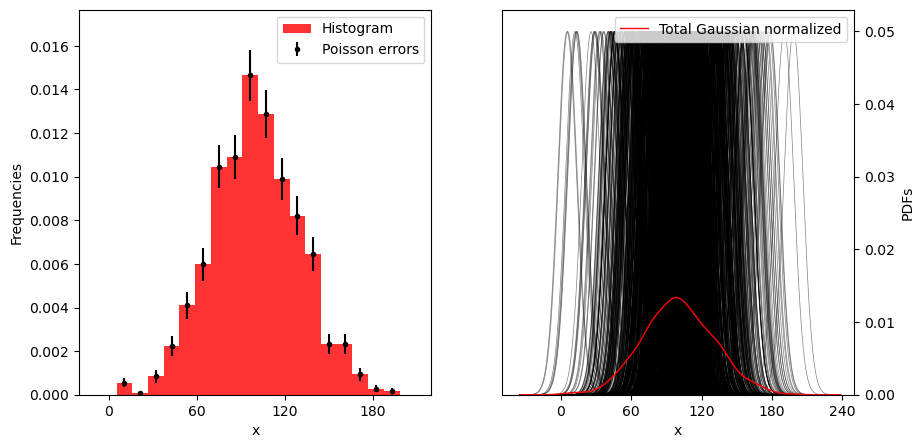

In [173]:
mu = 100
sigma = 30

G = npr.randn(1000)
Z = mu + sigma * G

# Bins Scott rule
bin_width = 3.5 * np.std(Z) / (len(Z) ** (1/3))
n_bins = int((Z.max() - Z.min()) / bin_width)

# Figure
fig, (H, Gauss) = plt.subplots(nrows=1, ncols=2, figsize=(10, 5)) 
counts, bin_edges, _ = H.hist(Z, bins=n_bins, density=True, label="Histogram", color='red', alpha=0.8)

# Poisson errors
raw_counts, _, _ = H.hist(Z, bins=n_bins, alpha=0)  
errors = np.sqrt(raw_counts) / (len(Z) * np.diff(bin_edges)) 
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])
H.errorbar(bin_centers, counts, yerr=errors, fmt='.', color='black', label='Poisson errors')

# Customizations Histo
H.set_ylabel("Frequencies")
H.set_xlabel("x")
H.set_xlim(mu-4*sigma, mu+4*sigma)
H.set_ylim(0, np.max(counts) + 0.003)
H.xaxis.set_major_locator(MultipleLocator(2*sigma))
H.legend(loc="upper right")

# Gaussians
std = 1.06*Z.std()*Z.size**(-1/5)
x = np.linspace(Z.min()-5*std, Z.max()+5*std, 1000)
pdfs = np.zeros((len(Z), len(x)))
for i,z in enumerate(Z):
    pdfs[i,:] = norm.pdf(x, loc=z, scale=std)
    Gauss.plot(x, pdfs[i,:], color='black', linewidth=0.5, alpha=0.5)

#Sum Gaussians
total_gauss = pdfs.sum(axis=0) 
int_total_gauss = trapz(total_gauss, x)
total_gauss_norm = total_gauss / int_total_gauss
Gauss.plot(x, total_gauss_norm, label="Total Gaussian normalized", color='red', linewidth=1)
    
# Customizations Gauss
Gauss.set_ylabel("PDFs")
Gauss.set_xlabel("x")
Gauss.set_xlim(mu-5*sigma, mu+5*sigma)
Gauss.set_ylim(0, np.max(pdfs) + 0.003)
Gauss.xaxis.set_major_locator(MultipleLocator(2*sigma))
Gauss.yaxis.set_label_position("right") 
    Gauss.yaxis.tick_right() 
Gauss.legend(loc="upper right")

plt.show()

2\. **Color-coded scatter plot**

Produce a scatter plot out of a dataset with two categories

* Write a function that generate a 2D datasets of 2 categories. Each category should distribute as a 2D gaussian with a given mean and std (clearly it is better to have different values means..)
* Display the dataset in a scatter plot marking the two categories with different marker colors.

An example is given below

You can try to make the procedure more general by allowing a given number $n\ge 2$ of categories

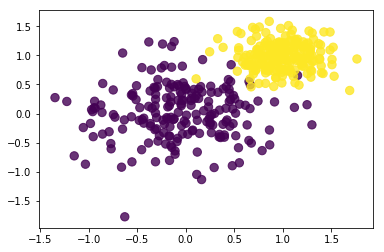

In [172]:
#! wget https://www.dropbox.com/s/u4y3k4kk5tc7j46/two_categories_scatter_plot.png
from IPython.display import Image
Image('two_categories_scatter_plot.png')

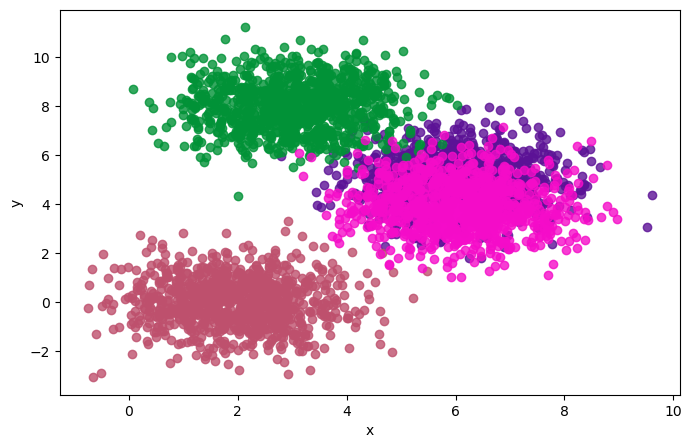

In [215]:
n = 1000
n_category = 4

range_max_mean = 10
range_max_std = 2

def generate_means(n_category):
    means = []
    for i in range(n_category):
        a = [npr.randint(0,range_max_mean), npr.randint(0,range_max_mean)]
        means.append(a)
    return means

def generate_cov(n_category):
    cov = []
    for i in range(n_category):
        a = [[npr.randint(1,range_max_std),0], [0,npr.randint(1,range_max_std)]]
        cov.append(a)
    return cov

def generate_dataset(n, mean, cov):
    data = npr.multivariate_normal(mean, cov, n)
    return data
   
    
means = generate_means(n_category) 
cov = generate_cov(n_category)

fig, ax = plt.subplots(figsize=(8, 5)) 
for i in range(n_category):
    dataset = generate_dataset(n, means[i], cov[i])
    ax.scatter(dataset[:, 0], dataset[:, 1], label=f'Category {i+1}', color=npr.rand(3,), alpha=0.8)


ax.set_xlabel("x")
ax.set_ylabel("y")

plt.show()

3\. **Profile plot**

Produce a profile plot from a scatter plot.
* Download the following dataset and load it as a pandas dataframe:
```bash
wget https://www.dropbox.com/s/hgnvyj9abatk8g6/residuals_261.npy
```
Note that you should use the `np.load()` function to load the file as a numpy array, call the `.item()` method, and then pass it to the `pd.DataFrame()` constructor.
* Inspect the dataset, you'll find two variables (features)
* Clean the sample by selecting the entries (rows) with the variable "residual" in absolute value smaller than 2
* perform a linear regression of "residuals" versus "distances" using `scipy.stats.linregress()` 
* plot a seaborn jointplot of  "residuals" versus "distances", having seaborn performing a linear regression. The result of the regression should be displayed on the plot
* Fill 3 numpy arrays
  * x, serving as an array of bin centers for the "distance" variable. It should range from 0 to 20 with reasonable number of steps (bins)
  * y, the mean values of the "residuals", estimated in slices (bins) of "distance"
  * erry, the standard deviation of the  of the "residuals", estimated in slices (bins) of "distance"
* Plot the profile plot on top of the scatter plot

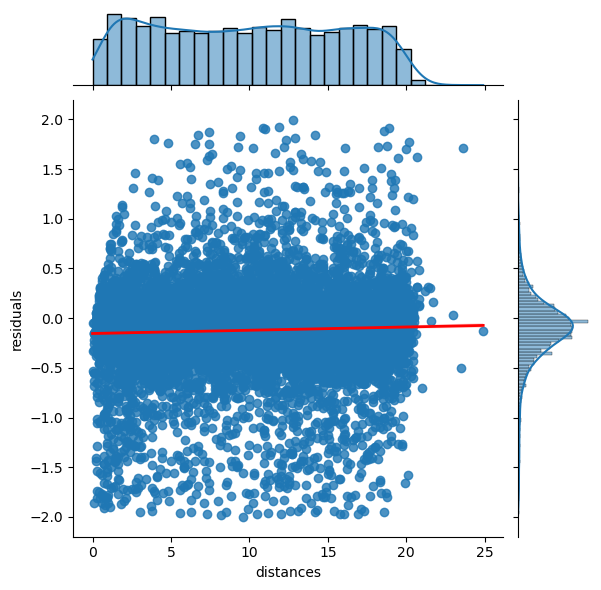

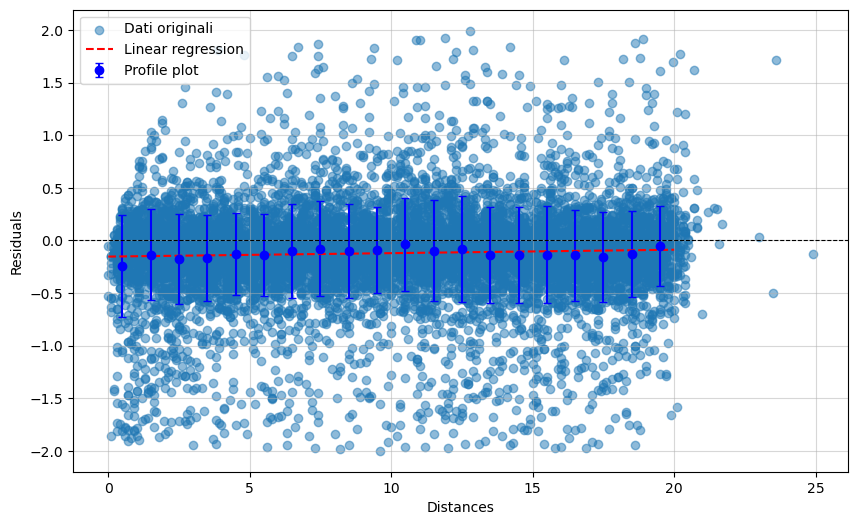

In [66]:
data = np.load("residuals_261.npy", allow_pickle=True).item()
df = pd.DataFrame(data)

df_filtered = df[np.abs(df['residuals']) < 2]
regression = linregress(df_filtered['distances'], df_filtred['residuals'])


sns.jointplot(
    x="distances", 
    y="residuals", 
    data=df_filtered, 
    kind="reg", 
    line_kws={"color": "red", "linewidth": 2}, 
    height=6)


n_bins = 20 
bin_edges = np.linspace(0, 20, n_bins+1 )  
x = 0.5 * (bin_edges[:-1] + bin_edges[1:])

y = np.zeros(n_bins)
erry = np.zeros(n_bins)

for i in range(n_bins):
    bin_mask = (df_filtered['distances'] >= bin_edges[i]) & (df_filtered['distances'] < bin_edges[i + 1])
    bin_residuals = df_filtered.loc[bin_mask, 'residuals']
    
    y[i] = bin_residuals.mean() if not bin_residuals.empty else np.nan
    erry[i] = bin_residuals.std() if not bin_residuals.empty else np.nan

    
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered['distances'], df_filtered['residuals'], alpha=0.5, label="Dati originali")
plt.errorbar(x, y, yerr=erry, fmt='o', color='blue', label="Profile plot", capsize=3)

# Linear regression
x_reg = np.linspace(0, 20, 100)
y_reg = regression.slope * x_reg + regression.intercept
plt.plot(x_reg, y_reg, color='red', linestyle='--', label="Linear regression")

# Customizations
plt.xlabel("Distances")
plt.ylabel("Residuals")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.legend()
plt.grid(alpha=0.5)

plt.show()